<a href="https://colab.research.google.com/github/IgnacioPardo/DavidBlade/blob/main/David_Blade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 **DAVID BLADE**

## 🌍 [Web](https://bit.ly/3H0t986)

Experimento basado en [McCoy, J. P., & Ullman, T. D. (2018). A Minimal Turing Test. Journal of Experimental Social Psychology, 79](https://www.sciencedirect.com/science/article/pii/S0022103117303980?via%3Dihub)



# 🛠 Survey.txt Tools

### Para generar Psytoolkit survey.txt


A partir de un set de 4 categorias, cada una con entre 4 y 6 palabras, se genera la encuesta formateada para ser integrada en psytoolkit.

```python
# Ejemplo
"Palabras": {
    "Affect": {"Empatia", "Emocion", "Sentimientos", "Simpatia", "Felicidad"},
    "LDBP": {"Vivo", "Dolor", "Sexo", "Caca"},
    "Lunf": {"Birra", "Boludo", "Bondi", "Che", "Morfar"},
    "Tech": {"Celular", "Dron", "Procesador", "Robot", "Smart-TV"},
}
```



Se genera de la siguiente forma.

- Calcula el producto cartesiano de todos los sets de palabras. Esto permite que no compitan palabras de la misma categoria ya que no lo estamos evaluando.

- Se genera un set conteniendo todos los posibles subsets de la forma {palabra_cat1, palabra_cat2, palabra_cat3, palabra_cat4}. A partir de el, se seleccionan todas las combinaciones posibles para agarrar sets de 2 palabras.

- Luego se selecciona una cantidad qB de lotes, cada uno conteniendo una cantidad qI de sets de 2 palabras.

En funcion a este set de qB sets de qI palabras, se genera un archivo survey.txt que funciona de la siguiente forma:

- Comienza con una eleccion al azar de un indice entre 0 y qB, en funcion a el, el survey elijira un lote de preguntas mediante un salto condicional.

- Cada lote cuenta con qI labels, cada una con un slider en el cual los extremos pertenecen a 1 de las 4 categorias de las que se "enfrentan", las cuales se indican en el nombre de la label para ser usados a la hora de procesar los datos.

- Ademas, se generan dos preguntas de control, que a su vez sirven de destino para los saltos condicionales, tanto para el comienzo de un lote como para el final de el.

Tanto la cantidad de categorias como la cantidad de palabras por cada categoria son escalables a lo que el experimento amerite ya que la survey y los resultados se generan de forma dinamica.

In [85]:
import itertools
import numpy as np
import random

In [86]:
# Palabras por categoria y descripcion

cat_descrip = {
    "Descripcion": {
        "Affect": "Afectos",
        "LDBP": "Vida y muerte, funciones corporales y blasfemias",
        "Lunf": "Lunfardo",
        "Tech": "Tecnología",
    },
    "Palabras": {
        "Affect": {"Empatia", "Emocion", "Sentimientos", "Simpatia", "Felicidad"},
        "LDBP": {"Vivo", "Dolor", "Sexo", "Caca"},
        "Lunf": {"Birra", "Boludo", "Bondi", "Che", "Morfar"},
        "Tech": {"Celular", "Dron", "Procesador", "Robot", "Smart-TV"},
    },
}


#Palabras por categoria
words = cat_descrip["Palabras"]

# ID numerico por categoria
word_id = {k: i for i, k in enumerate(words.keys())}
		
# Categoria por palabra
relations = {word:cat for cat, cat_words in words.items() for word in cat_words}

In [87]:
# Calcula el producto cartesiano de todos los sets de palabras. Esto permite que no compitan palabras de la misma categoria ya que no lo estamos evaluando.
# ((x,y) for x in A for y in B)
prod = list(itertools.product(*words.values()))

# Combinaciones del tipo (catX, catY) entre (op_cat1, op_cat2, op_cat3, op_cat4)
arr = np.array([list(itertools.permutations(list(group), 2)) for group in prod])

# Reshape -> array de (catX, catY)
arr = arr.reshape((arr.shape[0] * arr.shape[1], 2))
combinations = arr.tolist()

# Permutaciones
# Las combinaciones se convierten a string de la forma "cat1_cat2" para ser usadas como key en el diccionario unit. Los valores son set {cat1, cat2}
unit = {
    "_".join(sorted([relations[w] for w in pair]) + sorted(pair)): set(pair)
    for pair in combinations
}

# Para aprovechar distinto los valores obtenidos.
# perm = {"_".join(sorted(pair)): {ws[1]: ws[0] for ws in [(w, relations[w]) for w in pair]} for pair in combinations}

In [88]:
# Psytoolkit range slider template
template = "l: Batch_index\nt: range\nq: ¿Que palabra la dijo el robot?\n"
slider = "- {min=-1,max=1,start=0,left=leftVal,right=rightVal,by=0}\n"

In [89]:
qB = 10
qI = 10

In [90]:
# Batch generator, qB: Batch quantity
batches = [random.sample([set(s) for s in unit.values()], qI) for _ in range(qB)]

In [91]:
# Psytoolkit survey generator

!rm -rf survey.txt
with open("survey.txt", "a") as survey_file:
    survey_file.write("l: chooserandom\n")
    survey_file.write("t: set\n")
    survey_file.write("- random 1 {q}\n".format(q=qB))

    survey_file.write("\n")

    survey_file.write("l:\n")
    survey_file.write("t: jump\n")

    for i in range(qB):
        survey_file.write(
            "- if $chooserandom == {iB1} then goto Batch_{iB2}\n".format(
                iB1=i + 1, iB2=i + 1
            )
        )

    survey_file.write("\n")

    for i, batch in enumerate(batches):
        survey_file.write("\n")
        survey_file.write("l: Batch_{iB}\n".format(iB=i + 1))
        survey_file.write("t: radio\n")
        survey_file.write("q: ¿Quien es David Blade?\n")
        survey_file.write("- 🤖 Un Robot\n")
        survey_file.write("- 👥 Tu amigo\n")
        survey_file.write("\n")

        for j, pair in enumerate(batch):
            left, right = list(pair)
            label = (
                "_"
                + relations[left]
                + "_"
                + relations[right]
                + "_"
                + str(i + 1)
                + "_"
                + str(j + 1)
            )
            survey_file.write(template.replace("index", label))
            survey_file.write(
                slider.replace("leftVal", left).replace("rightVal", right)
            )
            survey_file.write("\n")
        survey_file.write("l:\n")
        survey_file.write("t: jump\n")
        survey_file.write("- goto end\n")
        survey_file.write("\n")

    survey_file.write("\n")
    survey_file.write("l: end\n")
    survey_file.write("t: radio\n")
    survey_file.write("q: ¿Quien es David Blade?\n")
    survey_file.write("- 🤖 Un Robot\n")
    survey_file.write("- 👥 Tu amigo\n")
    survey_file.write("\n")

# 🧮 Survey Data
Postprocessing de los datos obtenidos en Psytoolkit

In [92]:
import pandas as pd
from IPython.display import display, Markdown, HTML

In [93]:
#Psytoolkit survey data
df = pd.read_csv('data.csv') 
df

,participant,chooserandom:1,Batch_1:1,Batch__Lunf_Affect_1_1:1,Batch__LDBP_Tech_1_2:1,Batch__Lunf_Affect_1_3:1,Batch__LDBP_Affect_1_4:1,Batch__LDBP_Affect_1_5:1,Batch__Affect_Lunf_1_6:1,Batch__Lunf_LDBP_1_7:1,Batch__Affect_LDBP_1_8:1,Batch__Lunf_Affect_1_9:1,Batch__LDBP_Tech_1_10:1,Batch_2:1,Batch__Tech_Affect_2_1:1,Batch__Tech_Affect_2_2:1,Batch__Tech_Lunf_2_3:1,Batch__LDBP_Affect_2_4:1,Batch__Lunf_Affect_2_5:1,Batch__Lunf_Affect_2_6:1,Batch__Lunf_Affect_2_7:1,Batch__Lunf_Affect_2_8:1,Batch__Tech_Affect_2_9:1,Batch__Lunf_LDBP_2_10:1,Batch_3:1,Batch__LDBP_Affect_3_1:1,Batch__Affect_LDBP_3_2:1,Batch__LDBP_Affect_3_3:1,Batch__Lunf_Affect_3_4:1,Batch__LDBP_Lunf_3_5:1,Batch__Affect_LDBP_3_6:1,Batch__Lunf_Tech_3_7:1,Batch__LDBP_Lunf_3_8:1,Batch__Tech_LDBP_3_9:1,Batch__Lunf_Affect_3_10:1,Batch_4:1,Batch__Lunf_Affect_4_1:1,Batch__Tech_Affect_4_2:1,Batch__Affect_Lunf_4_3:1,Batch__Tech_Lunf_4_4:1,...,Batch__Tech_Affect_7_9:1,Batch__Tech_Affect_7_10:1,Batch_8:1,Batch__Affect_Tech_8_1:1,Batch__LDBP_Tech_8_2:1,Batch__Tech_LDBP_8_3:1,Batch__Tech_Lunf_8_4:1,Batch__LDBP_Lunf_8_5:1,Batch__LDBP_Affect_8_6:1,Batch__Lunf_Affect_8_7:1,Batch__Affect_LDBP_8_8:1,Batch__LDBP_Lunf_8_9:1,Batch__Affect_Lunf_8_10:1,Batch_9:1,Batch__Affect_Lunf_9_1:1,Batch__LDBP_Lunf_9_2:1,Batch__Affect_Lunf_9_3:1,Batch__Affect_Tech_9_4:1,Batch__Tech_LDBP_9_5:1,Batch__Affect_Tech_9_6:1,Batch__Affect_LDBP_9_7:1,Batch__Tech_LDBP_9_8:1,Batch__Tech_Affect_9_9:1,Batch__LDBP_Affect_9_10:1,Batch_10:1,Batch__Lunf_Affect_10_1:1,Batch__LDBP_Affect_10_2:1,Batch__Lunf_LDBP_10_3:1,Batch__Tech_Lunf_10_4:1,Batch__Lunf_Affect_10_5:1,Batch__Tech_LDBP_10_6:1,Batch__Affect_LDBP_10_7:1,Batch__Tech_Affect_10_8:1,Batch__Tech_Lunf_10_9:1,Batch__Lunf_LDBP_10_10:1,end:1,TIME_start,TIME_end,TIME_total,Unnamed: 116
0,s.6fb38ba4-36e9-4135-91f9-3d205128d252.txt,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2021-11-05-14-16,2021-11-05-14-17,1.0,NaN
1,s.a68d1b66-d5d1-4f8a-bc57-5344ff62d37c.txt,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-11-05-14-17,NaN,NaN,NaN
2,s.d1d511c3-0448-41c1-a073-0c12794500b0.txt,1,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2021-11-05-14-17,2021-11-05-14-19,2.0,NaN
3,s.df126368-135e-460b-91b5-8b82194c2f55.txt,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,2021-11-05-14-17,2021-11-05-14-19,2.0,NaN
4,s.7e01d23e-31f2-4c07-a0a8-0cb5ea5ae491.txt,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2021-11-05-14-18,2021-11-05-14-19,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

# 🧠 Results

In [94]:
# Pregunta de control

# ¿Quien es DAVID BLADE?
# 1. 🤖
# 2. 👥

state_control = True

control_keys = ["Batch_{_i}:1".format(_i=i + 1) for i in range(qB)] + ["end:1"]


# Convierte 2 en 0 y deja 1 en 1.
# -(x - 2) = y
# -(2 - 2) = -0 = 0
# -(1 - 2) = 1
full = ((df[control_keys] - 2) * -1).replace(to_replace=-0.0, value=0).fillna(0)
control = full[control_keys[0]]

for i in range(10):
    control = control + full[control_keys[i + 1]]

control = control.replace(to_replace=1, value=0)
control = control.replace(to_replace=2, value=1)

In [95]:
# Llamamos partido al evento de que una categoria haya sido marcada como "robot" contra otra.
# Llamamos torneo a todos los posibles partidos jugados entre 2 categorias.
# Cada set de Matches es un set del estilo {cat1, cat2} para todas las combinaciones cat1-cat2 entre el total de categorias.

matches = {
    frozenset(sorted(list(t))) for t in list(itertools.permutations(words.keys(), 2))
}

# Tournament es un diccionario de la forma key partido, y su valor es un diccionario conteniendo equipo -> partidos ganados contra el otro equipo.
# Ejemplo {'Affect_LDBP': {'Affect': 10, 'LDBP': 5}

tournament = {
    sorted(list(match))[0]
    + "_"
    + sorted(list(match))[1]: {list(match)[0]: 0, list(match)[1]: 0}
    for match in matches
}

In [96]:
for_stats = {"Participante": [], "OpcionA": [], "OpcionB": [], "Respuesta": []}

In [97]:
# Contabiliza los "partidos" de los datos obtenidos de psytoolkit
for k in df:
    if "Batch__" in k:
        # El prefijo "Batch__" en una label implica que la columna es un enfrentamiento, a diferencia de informacion extra del experimento (Participante/duracion/indice)
        # Del tipo Batch__cat1_cat2

        # Multiplica la columna de respuestas por la columna de control.
        # Invalida las respuestas de haber respondido mal la pregunta de control.
        if state_control:
            df.at[k] = df[k] * control

        # Obtiene las categorias que juegan el partido.
        players = k.split("Batch__")[1].split("_")[:2]

        # Obtiene el tipo de partido
        match = "_".join(sorted(players))
        left = players[0]
        right = players[1]

        # Determina el ganador del partido en funcion de la respuesta y la suma en el torneo.
        for i, v in enumerate(df[k]):
            if v == -1:
                tournament[match][left] += 1
                for_stats["Participante"].append(i)
                for_stats["OpcionA"].append(word_id[left])
                for_stats["OpcionB"].append(word_id[right])
                for_stats["Respuesta"].append(word_id[left])
            elif v == 1:
                tournament[match][right] += 1
                for_stats["Participante"].append(i)
                for_stats["OpcionA"].append(word_id[left])
                for_stats["OpcionB"].append(word_id[right])
                for_stats["Respuesta"].append(word_id[right])

In [98]:
tournament = pd.DataFrame(tournament)
tournament = tournament.fillna(0).astype(int)

In [99]:
# Direccion de los nodos
graph_relations = []

# Cantidad de veces que una categoria gano mas partidos contra otra categoria

won = {word_id[word]: 0 for word in words}

#
conf = pd.DataFrame({c: {c2: np.nan for c2 in words} for c in words})


for k in tournament:
    if k != "sum" and k != "pos":
        cat1, cat2 = k.split("_")
        a, b = tournament[k][cat1], tournament[k][cat2]

        tot = a + b

        # a: cantidad de veces que cat1 le gano a cat2
        # b: cantidad de veces que cat2 le gano a cat1

        # Si cat1 le gano mas veces a cat2 que cat2 a cat1, la direccion en el grafo va de cat1 -> cat2
        if a > b:
            won[word_id[cat1]] += 1
            graph_relations.append((word_id[cat1], word_id[cat2]))

            conf[cat1][cat2] = a / tot * 100

        elif a < b:
            # La direccion en el grafo va de cat2 -> cat1
            graph_relations.append((word_id[cat2], word_id[cat1]))
            won[word_id[cat2]] += 1

            conf[cat1][cat2] = b / tot * 100
        else:
            # La relacion entre los nodos de cat1 y cat2 es bidireccional
            graph_relations.append((word_id[cat2], word_id[cat1]))
            graph_relations.append((word_id[cat1], word_id[cat2]))
            conf[cat1][cat2] = 50

In [100]:
import networkx as nx
import matplotlib.pyplot as plt

In [101]:
# Categoria by ID
labels = {i: k for k, i in word_id.items()}

options = {
    "font_size": 12,
    "node_size": 3000,
    "node_color": [(0, 0, 0, 0) for _ in range(len(labels))],
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
    "labels": labels,
    "connectionstyle": "arc3,rad=0",
}

# Para ordenar el torneo en funcion de sus ordenes, basado por los valores del diccionario won
ordered_tournament = tournament
ordered_tournament["pos"] = pd.Series([0, 0, 0, 0])

G = nx.DiGraph(graph_relations)

# Posicion para los 4 nodos del grafo
pos = [(0.5, 1), (0, 0.5), (1, 0.5), (0.5, 0)]

# Orden de los labels (medido por partidos ganados)
order = sorted(won.items(), key=lambda item: item[1], reverse=True)

# coordenadas por categoria
l_pos = {}

# Itera por las categorias
for i, n in enumerate(order):

    # Setea la posicion de la categoria en el DataFrame del torneo
    ordered_tournament.at[labels[n[0]], "pos"] = len(order) - (i + 1)

    # Setea las coordenadas del nodo para la categoria
    l_pos[n[0]] = pos[i]
    if i == 2:
        l_pos[order[i - 1][0]] = (pos[i - 1][0], 0.75)
        l_pos[n[0]] = (pos[i][0], 0.25)

# Results

### 👥 **364** participantes

### 🏆 **3181** partidos

<br><br>

### De mas a menos roboticas

,Affect_Tech,LDBP_Tech,LDBP_Lunf,Lunf_Tech,Affect_Lunf,Affect_LDBP
Tech,260,211,0,427,0,0
Affect,228,0,0,0,539,378
LDBP,0,143,281,0,0,311
Lunf,0,0,104,123,176,0


### Relacion categoria-categoria

🤖,🧠
Tech,Affect
Tech,LDBP
LDBP,Lunf
Tech,Lunf
Affect,Lunf
Affect,LDBP


### Depth

,Affect,LDBP,Lunf
Tech,53.278689,59.604520,77.636364
Lunf,75.384615,72.987013,nan
LDBP,54.862119,nan,nan


<br>

### Grafo

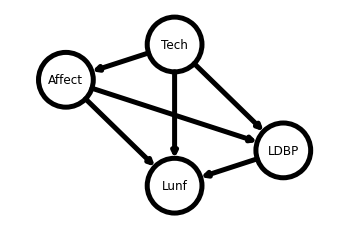

<br><br>

### Categorias

,Descripcion,Palabras
Affect,Afectos,"{Emocion, Sentimientos, Simpatia, Empatia, Fel..."
LDBP,"Vida y muerte, funciones corporales y blasfemias","{Vivo, Dolor, Sexo, Caca}"
Lunf,Lunfardo,"{Bondi, Birra, Che, Morfar, Boludo}"
Tech,Tecnología,"{Robot, Dron, Celular, Smart-TV, Procesador}"


<br><br>

In [115]:
display(Markdown("# Results"))

qP = max(for_stats["Participante"]) + 1
qR = sum([sum(list(ordered_tournament[s])) for s in ordered_tournament][:-1])

display(Markdown("### 👥 **" + str(qP) + "** participantes"))
display(Markdown("### 🏆 **" + str(qR) + "** partidos"))


display(Markdown("<br><br>"))

display(Markdown("### De mas a menos roboticas"))
display(ordered_tournament.sort_values(by=["pos"], ascending=False).drop("pos", axis=1))

display(Markdown("### Relacion categoria-categoria"))

names = {0: "🤖", 1: "🧠"}

display(
    HTML(
        pd.DataFrame([[labels[i], labels[j]] for i, j in graph_relations])
        .rename(columns=names)
        .to_html(index=False)
    )
)

display(Markdown("### Depth"))

display(
    conf.iloc[::-1]
    .drop("Tech", axis=1)
    .drop("Affect", axis=0)
    .style.background_gradient(cmap="Wistia", axis=None)
)

display(Markdown("<br>"))

display(Markdown("### Grafo"))
nx.draw_networkx(G, l_pos, **options)

ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
# plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.show()


display(Markdown("<br><br>"))

display(Markdown("### Categorias"))


full = {
    "Descripcion": cat_descrip["Descripcion"],
    "Palabras": {
        cat: {"word_" + str(i): w for i, w in enumerate(cat_descrip["Palabras"][cat])}
        for cat in cat_descrip["Palabras"]
    },
}

display(pd.DataFrame(cat_descrip))

display(Markdown("<br><br>"))

# 📄 Stats

In [103]:
from scipy import stats
from statsmodels.stats import proportion
import matplotlib.pyplot as plt

In [104]:
dataMcCoy = pd.DataFrame(for_stats).sort_values(by=['Participante'], ascending=True)

In [105]:
dataMcCoy.to_excel("DavidBlade_data.xlsx")  

In [106]:
dataMcCoy

,Participante,OpcionA,OpcionB,Respuesta
2064,0,3,0,3
1833,0,2,0,2
2036,0,3,1,1
2008,0,2,3,3
1980,0,3,2,3
...,...,...,...,...
220,363,1,3,3
158,363,2,1,1
179,363,0,1,0
47,363,1,3,1


In [107]:
# Sabemos que cada palabra corresponde a una de las 4 posibles categorías
# Primero me fijo en qué fila (cada una de las preguntas) se incluyó alguna palabra de la categoría 1 (indexCat1),
# La 2 (indexCat2) y etc.
indexCat1 = (dataMcCoy["OpcionA"]==0) | (dataMcCoy["OpcionB"]==0) # Se incluyó la categoría 1 en la pregunta (ya sea en la posición A o bien la B)
indexCat2 = (dataMcCoy["OpcionA"]==1) | (dataMcCoy["OpcionB"]==1)
indexCat3 = (dataMcCoy["OpcionA"]==2) | (dataMcCoy["OpcionB"]==2)
indexCat4 = (dataMcCoy["OpcionA"]==3) | (dataMcCoy["OpcionB"]==3)
#Gracias a los índices puedo filtrar los datos y creo 4 matrices distintas
cat1 = dataMcCoy[indexCat1] # Esta cuenta con todas las veces que se incluyó una palabra de la categoría 1 en la pregunta
cat2 = dataMcCoy[indexCat2] # De la categoría 2
cat3 = dataMcCoy[indexCat3]
cat4 = dataMcCoy[indexCat4]

#Creo un vector que indica cuántas veces se eligió cada categoría
#En este caso 'elegir' quiere decir que se consideró como la palabra propuesta por una persona
countCategories = np.array([np.size(cat1[cat1["Respuesta"]==0]), np.size(cat2[cat2["Respuesta"]==1]), 
                  np.size(cat3[cat3["Respuesta"]==2]), np.size(cat4[cat4["Respuesta"]==3])])
# Me fijo la cantidad de preguntas en las que se incluyo cada categoria
sampleSizeCat = np.array([np.size(cat1), np.size(cat2), np.size(cat3), np.size(cat4)])

# Notar que como trabajo con NumPy, en una sola línea estoy realizando las 4 divisiones
proportionCategories = countCategories/sampleSizeCat
proportionValues = proportionCategories
# Calculo el error standar para una proporcion
sepValues = proportion.std_prop(proportionCategories,sampleSizeCat)

print("La proporción de veces que la categoría '"+labels[0]+"' fue elegida como humana es: ",round(proportionValues[0],3),"+-",round(sepValues[0],3),
        "\nPara la categoría '"+labels[1]+"':",round(proportionValues[1],3),"+-",round(sepValues[1],3),
        "\nLa '"+labels[2]+"'",round(proportionValues[2],3),"+-",round(sepValues[2],3),
        "\nLa '"+labels[3]+"'",round(proportionValues[3],3),"+-",round(sepValues[3],3))

La proporción de veces que la categoría 'Affect' fue elegida como humana es:  0.605 +- 0.006 
Para la categoría 'LDBP': 0.515 +- 0.007 
La 'Lunf' 0.244 +- 0.005 
La 'Tech' 0.645 +- 0.006


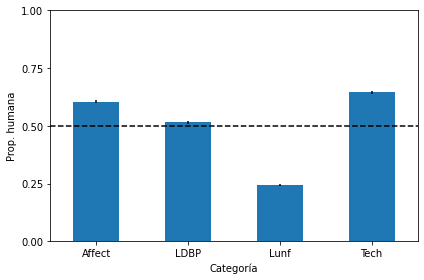

In [108]:
## Graficaremos lo calculado en la celda anterior
# La proporcion  de cada grupo y su error standard
xAxis = np.arange(4)
fig, ax = plt.subplots(1)
# Dado que los valores esan acotados entre 0 y 1, utilizo grafico de barras
plt.axhline(y=0.5, color = "black", linestyle='dashed')

#White axis
"""
ax.spines['bottom'].set_color('#ffffff')
ax.spines['top'].set_color('#ffffff') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
ax.title.set_color('white')
"""

plt.bar(xAxis, proportionValues, yerr = sepValues, width=0.5, color='tab:blue', align='center')
plt.ylim([0, 1])
plt.yticks(np.arange(0,1.1,0.25))
plt.xticks(xAxis,labels.values())
plt.xlim(-0.5,3.5) 
plt.ylabel('Prop. humana')
plt.xlabel('Categoría')
plt.tight_layout()

plt.savefig('proportion_chart.png', transparent=True)

In [109]:
#Qué categoría fue considerada como más humana que el resto?
#Una forma rápida de responder esta pregunta es ordenandolas por los valores presentados en la figura anterior
#print(np.argsort(proportionCategories)[::-1]) # Me ordena las categorías de menor a mayor y yo luego lo invieto ([::-1]) para verlas de mayor a menor
# Recuerden que el 0 es la cat 1 ó A, sino le puedo sumar uno y listo:
print([labels[cat] for cat in np.argsort(proportionCategories)[::-1]])
#[2 3 1 4] quiere decir que: La categoría '2' es la más humana, dsp la 3, dsp la 1 y última la 4


# Puedo hacer los test estadísticos entre categorías para ver si esas diferencias son significativas y 
# Rechazar la H0 de que son iguales, que no hubo diferencias

# Elijo las categorías a comparar (recuerden que la 1 es la 0 y así)
catA = 0 # Categoria 1
catB = 1 # vs Categoria 2
stat, pval = proportion.proportions_ztest(countCategories[[catA,catB]], sampleSizeCat[[catA,catB]])
print("z:",stat, "p:",pval)

catA = 1 # Categoria 2
catB = 2 # vs Categoria 3
stat, pval = proportion.proportions_ztest(countCategories[[catA,catB]], sampleSizeCat[[catA,catB]])
print("z:",stat, "p:",pval)

catA = 1 # Categoria 2
catB = 3 # vs Categoria 4
stat, pval = proportion.proportions_ztest(countCategories[[catA,catB]], sampleSizeCat[[catA,catB]])
print("z:",stat, "p:",pval)

# En total sería 6 comparaciones. Pueden hacer todas o bien categorías consecutivas en el 'ranking' final.
# Es decir, la que salió 1ra contra la 2da. La 2da contra la 3ra y la 3ra contra la 4ta

['Tech', 'Affect', 'LDBP', 'Lunf']
z: 10.41565226353198 p: 2.1035066534171505e-25
z: 31.00323268777247 p: 4.875952988174148e-211
z: -14.025798146143222 p: 1.0838584451556511e-44


In [110]:
# Para este ejemplo, las categorías consecutivas en el ranking, sería:
catA = 1 # Categoria 2
catB = 2 # vs Categoria 3
stat, pval = proportion.proportions_ztest(countCategories[[catA,catB]], sampleSizeCat[[catA,catB]])
print("z:",stat, "p:",pval)

catA = 2 # Categoria 3
catB = 0 # vs Categoria 1
stat, pval = proportion.proportions_ztest(countCategories[[catA,catB]], sampleSizeCat[[catA,catB]])
print("z:",stat, "p:",pval)

catA = 0 # Categoria 1
catB = 3 # vs Categoria 4
stat, pval = proportion.proportions_ztest(countCategories[[catA,catB]], sampleSizeCat[[catA,catB]])
print("z:",stat, "p:",pval)

# Al estar cerca, es de esperar que los p-valores sean altos

z: 31.00323268777247 p: 4.875952988174148e-211
z: -43.205645503713406 p: 0.0
z: -4.664960406722382 p: 3.086764672599477e-06


In [111]:
# También podemos mirar para cada par de categorías cuál fue considerada más humana en promedio
# Del análisis anterior sabemos en qué filas se incluyó cada categoría
# Gracias al AND (&) podemos ver par por par
cat12 = dataMcCoy[indexCat1 & indexCat2] # En estas filas se preguntó por la cat 1 Y la 2
cat13 = dataMcCoy[indexCat1 & indexCat3] # En estas filas se preguntó por la cat 1 Y la 3
cat14 = dataMcCoy[indexCat1 & indexCat4]
cat23 = dataMcCoy[indexCat2 & indexCat3]
cat24 = dataMcCoy[indexCat2 & indexCat4]
cat34 = dataMcCoy[indexCat3 & indexCat4]

#Creo un vector que indica cuántas veces se eligió cada categoría
#En este caso 'elegir' quiere decir que se consideró como la palabra propuesta por una persona
countPairs = np.array([np.size(cat12[cat12["Respuesta"]==0]), np.size(cat13[cat13["Respuesta"]==0]),np.size(cat14[cat14["Respuesta"]==0]),
                  np.size(cat23[cat23["Respuesta"]==1]), np.size(cat24[cat24["Respuesta"]==1]),
                  np.size(cat34[cat34["Respuesta"]==2])])
# Me fijo la cantidad de muestras que hay en cada grupo
sampleSizePairs = np.array([np.size(cat12), np.size(cat13), np.size(cat14),
                        np.size(cat23),np.size(cat24),np.size(cat34)])

proportionPairs = countPairs/sampleSizePairs
proportionValues = proportionPairs
# Calculo el error standar para una proporcion
sepValues = proportion.std_prop(proportionPairs,sampleSizePairs)

print("La proporción de veces que la categoría "+labels[0]+" fue elegida por sobre la "+labels[1]+" es: ",round(proportionValues[0],3),"+-",round(sepValues[0],3),
        "\nPara "+labels[0]+" vs "+labels[2]+":",round(proportionValues[1],3),"+-",round(sepValues[1],3),
        "\n"+labels[0]+" vs "+labels[3]+":",round(proportionValues[2],3),"+-",round(sepValues[2],3),
        "\n"+labels[1]+" vs "+labels[2]+":",round(proportionValues[3],3),"+-",round(sepValues[3],3),
        "\n"+labels[1]+" vs "+labels[3]+":",round(proportionValues[4],3),"+-",round(sepValues[4],3),
        "\n"+labels[2]+" vs "+labels[3]+":",round(proportionValues[5],3),"+-",round(sepValues[5],3))

La proporción de veces que la categoría Affect fue elegida por sobre la LDBP es:  0.549 +- 0.009 
Para Affect vs Lunf: 0.754 +- 0.008 
Affect vs Tech: 0.467 +- 0.011 
LDBP vs Lunf: 0.73 +- 0.011 
LDBP vs Tech: 0.404 +- 0.013 
Lunf vs Tech: 0.224 +- 0.009


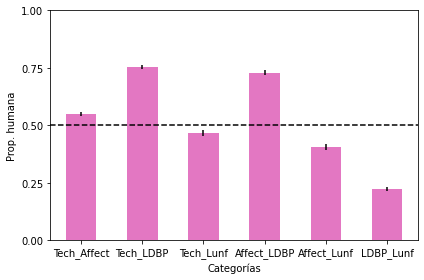

In [112]:
## Graficaremos lo calculado en la celda anterior
# La proporcion  de cada par de categorías y su error standardar
xAxis = np.arange(6)
# Dado que los valores esan acotados entre 0 y 1, utilizo grafico de barras
plt.axhline(y=0.5, color = "black", linestyle='dashed')


ax.spines['bottom'].set_color('#ffffff')
ax.spines['top'].set_color('#ffffff') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
ax.title.set_color('white')

plt.bar(xAxis, proportionValues, yerr = sepValues, width=0.5, color='tab:pink', align='center')
plt.ylim([0, 1])
plt.yticks(np.arange(0,1.1,0.25))
plt.xticks(xAxis,["Tech_Affect","Tech_LDBP","Tech_Lunf","Affect_LDBP","Affect_Lunf","LDBP_Lunf"])
plt.xlim(-0.5,5.5) 
plt.ylabel('Prop. humana')
plt.xlabel('Categorías')
plt.tight_layout()

plt.savefig('proportion_relation_chart.png', transparent=True)

# 🤖 **DAVID BLADE**

### 🧠 Integrantes: Luca Mazzarello - Camila Migdal Mamrud - Azul Noguera - Ignacio Pardo

### 📅 Fecha: Noviembre 2021

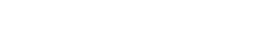